In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [44]:
def getprime(x):
    return x

def hashing(x, size):

    real_vector = np.zeros((len(x), 1), dtype=np.int32)
    for i in range(len(x)):
        real_vector[i] = (x[i]-1)%size

    return real_vector


class CMAC:

    def __init__(self, resolution, steps, bottom, C, mem):
        
        self.dim = len(resolution)
        self.C = C
        self.resolution = resolution
        self.steps = steps
        self.bottom = bottom
        self.size = getprime(mem)
        self.W = np.zeros((self.C, self.size))
        L = max(resolution)
        self.activate = np.zeros((self.dim, L, C))
        for d in range(self.dim):
            self.activate[d][0] = np.array([x for x in range(C)])
            for i in range(1, resolution[d]):
                self.activate[d][i] = self.activate[d][i-1]
                self.activate[d][i][(i-1)%C] += C
    
    def forward(self, x):
        assert len(x) == self.dim
        dim = self.dim
        address = np.zeros(self.C)
        radix = 1
        for d in range(dim):
            num = int((x[d]-self.bottom[d])//self.steps[d])
            assert num< self.resolution[d]
            acti = self.activate[d][num]
            address += radix*acti
            radix *= self.resolution[d] + self.C - 1
        address = hashing(address, self.size)
        self.work = address.astype(np.int32)
        self.out = np.sum(self.W[range(0, self.C), self.work])
        return self.out
    
    def backward(self, yhat, lr):
        total = len(self.work)
        delta = yhat-self.out
        self.W[range(0, self.C), self.work] += delta*lr/total
    
    def fit(self, X, Y, lr=0.1, iterations=1000):
        n = len(X)
        for t in range(iterations):
            i = random.randint(0, n-1)
            x, y=X[i], Y[i]
            self.forward(x)
            self.backward(y, lr)

In [47]:
x1, x2 = np.meshgrid(np.linspace(0, 6.2, 300), np.linspace(0, 6.2, 300))
X = np.concatenate((x1.reshape(1, -1), x2.reshape(1, -1)), axis=0).T
Y = np.sin(X[:, 0])*np.cos(X[:, 1])

model = CMAC([65, 65], [0.1, 0.1], [0, 0], 7, 5001)
model.fit(X, Y, iterations=20000)

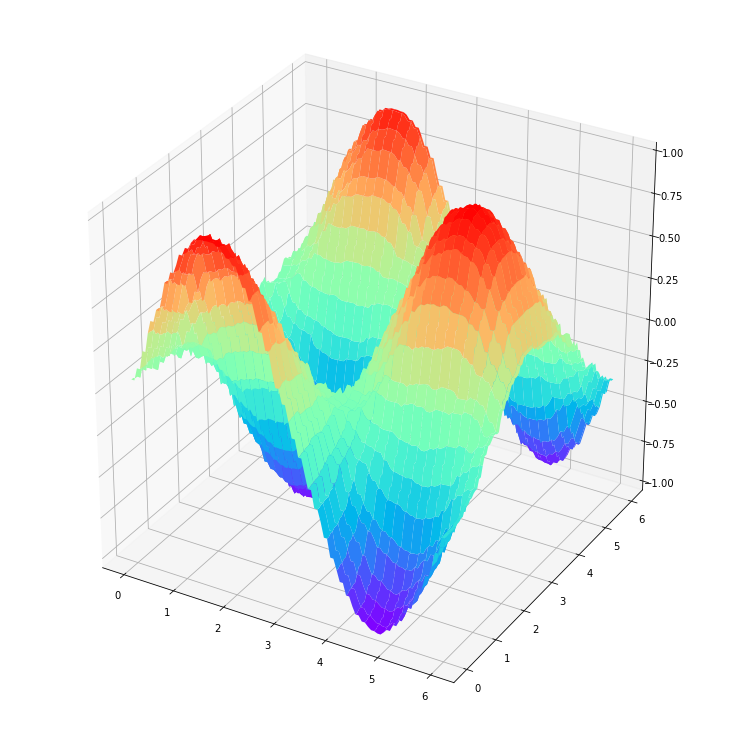

In [48]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import pyplot as pyplot

X, Y = np.meshgrid(np.linspace(0, 6, 101), np.linspace(0, 6, 101))
Z = np.zeros(X.shape)
for i in range(101):
    for j in range(101):
        x = np.array([X[i][j], Y[i][j]])
        Z[i][j] = model.forward(x)

fig = plt.figure(figsize=(10, 10))
axes3d = Axes3D(fig)
axes3d.plot_surface(X, Y, Z, cmap="rainbow")
